In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import SelectKBest, SelectPercentile

In [2]:
import matplotlib.pyplot as plt

In [3]:
# load dataset
df = pd.read_csv('data/mushrooms.csv')
df.shape

(8124, 23)

 **In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfitting**

In [4]:
### check target
df['class'].value_counts()/len(df)

e    0.517971
p    0.482029
Name: class, dtype: float64

In [5]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['class'], axis=1),  # drop the target
    df['class'],  # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((6499, 22), (1625, 22))

In [6]:
X_train.head(5)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
7434,k,s,g,f,n,f,w,b,p,e,...,s,w,w,p,w,t,p,w,s,g
7725,x,f,w,f,n,f,w,b,g,e,...,s,w,w,p,w,t,p,w,n,g
783,x,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,k,s,m
1928,f,s,w,f,n,f,w,b,h,t,...,f,w,w,p,w,o,e,k,s,g
7466,k,y,e,f,y,f,c,n,b,t,...,k,w,p,p,w,o,e,w,v,l


### 1. Constant features removing

In [9]:
constant_features = [feat for feat in X_train.columns if X_train[feat].nunique() == 1]

len(constant_features)

1

There is 1 variable that shows only 1 value in all the observations of the dataset and I can delete it.

In [10]:
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((6499, 21), (1625, 21))

In [11]:
constant_features

['veil-type']

### 2. Duplicated features removing

A new feature represents all columns' values as a string and after it's possible to check duplicate values in the new feature and find duplicate rows.

In [14]:
# check for duplicated features in the training set:
# create an empty dictionary, where we will store the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features that were found to be duplicated
columns_dupl = []

# iterate over every feature in our dataset:
for i in range(0, len(X_train.columns)):    
    # choose 1 feature:
    feat_1 = X_train.columns[i]
    
    # check if this feature has already been identified as a duplicate of another one.
    # If it was, it should be stored in our columns_dupl list.
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in columns_dupl:
        duplicated_feat_pairs[feat_1] = []
        # now, iterate over the remaining features of the dataset:
        for feat_2 in X_train.columns[i + 1:]:
            # check if this second feature is identical to the first one
            if X_train[feat_1].equals(X_train[feat_2]):
                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)               
                # and append it to our monitor list for duplicated variables
                columns_dupl.append(feat_2)

In [15]:
len(columns_dupl)
### There is no duplicated features

0

### 3. Categorical features encoding

OrdinalEncoder
Encode categorical features as an integer array.

The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.

In [16]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.NaN)

In [17]:
X_train_transform = ord_enc.fit_transform(X_train)
X_train_transform = pd.DataFrame(X_train_transform)

X_test_transform = ord_enc.transform(X_train)
X_test_transform = pd.DataFrame(X_train_transform)

In [18]:
X_train_transform.columns = X_train.columns
X_test_transform.columns = X_test.columns

### 4. Feature selection

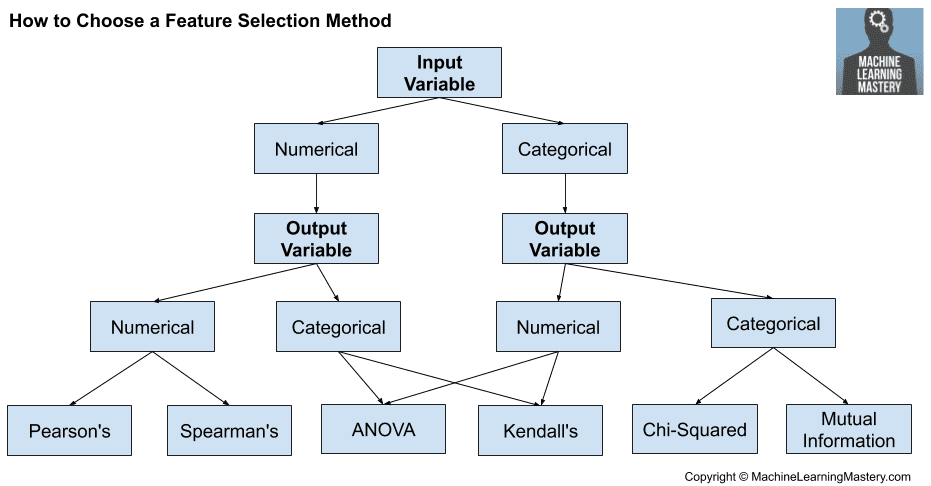

#### 4.1 Chi-Squared

In [19]:
f_score = chi2(X_train_transform, y_train)

# the 2 arrays of values : Chi2 statistics for each feature and P-values for each feature.
f_score

(array([1.48089426e+01, 1.77484752e+02, 8.98914003e+00, 9.46978512e+02,
        6.96783177e+01, 2.19421119e+00, 6.69282032e+02, 1.32194349e+03,
        4.85293025e+03, 3.23855630e+01, 9.60815748e+02, 1.70060352e+02,
        1.59678019e+02, 9.43646382e+01, 8.50193238e+01, 3.39786069e+00,
        2.13410113e+01, 1.51100895e+03, 3.22828476e+02, 2.51894968e+02,
        5.84982351e+02]),
 array([1.18970006e-004, 1.71641350e-040, 2.71588781e-003, 6.01923715e-208,
        6.98092814e-017, 1.38530110e-001, 1.43133831e-147, 1.92585378e-289,
        0.00000000e+000, 1.26422228e-008, 5.91126383e-211, 7.17769434e-039,
        1.33044771e-036, 2.62438948e-022, 2.95463343e-020, 6.52810336e-002,
        3.84418957e-006, 0.00000000e+000, 3.50595397e-072, 1.00305717e-056,
        3.09261540e-129]))

In [20]:
pvalues = pd.Series(f_score[1])
pvalues.index = X_train_transform.columns
pvalues.sort_values(ascending=True)

ring-type                    0.000000e+00
gill-color                   0.000000e+00
gill-size                   1.925854e-289
stalk-root                  5.911264e-211
bruises                     6.019237e-208
gill-spacing                1.431338e-147
habitat                     3.092615e-129
spore-print-color            3.505954e-72
population                   1.003057e-56
cap-surface                  1.716413e-40
stalk-surface-above-ring     7.177694e-39
stalk-surface-below-ring     1.330448e-36
stalk-color-above-ring       2.624389e-22
stalk-color-below-ring       2.954633e-20
odor                         6.980928e-17
stalk-shape                  1.264222e-08
ring-number                  3.844190e-06
cap-shape                    1.189700e-04
cap-color                    2.715888e-03
veil-color                   6.528103e-02
gill-attachment              1.385301e-01
dtype: float64

Contrarily to MI, where we were interested in the higher MI values, for the chi2, the smaller the p_value the more significant the feature is to predict the target.

### 4.2 Mutual information

The mutual information measures the reduction in uncertainty in variable A when variable B is known.

To select variables, we are interested in the mutual information between the predictor variables and the target. Higher mutual information values, indicate little uncertainty about the target Y given the predictor X.

[Mutual Information, Wikipedia](https://en.wikipedia.org/wiki/Mutual_information):

In [21]:
mi = mutual_info_classif(X_train_transform, y_train)

In [29]:
mi.sort_values(ascending=False)

odor                        0.626296
spore-print-color           0.324809
gill-color                  0.290093
ring-type                   0.219215
stalk-surface-above-ring    0.195007
stalk-surface-below-ring    0.185115
stalk-color-below-ring      0.170459
stalk-color-above-ring      0.165126
gill-size                   0.153313
population                  0.136336
bruises                     0.130846
habitat                     0.105361
stalk-root                  0.091017
gill-spacing                0.076717
cap-shape                   0.033474
ring-number                 0.029114
cap-surface                 0.028504
cap-color                   0.028286
gill-attachment             0.009634
veil-color                  0.006182
stalk-shape                 0.005561
dtype: float64

The smaller the value of the mi, the less information we can infer from the feature about the target

Text(0, 0.5, 'Mutual Information')

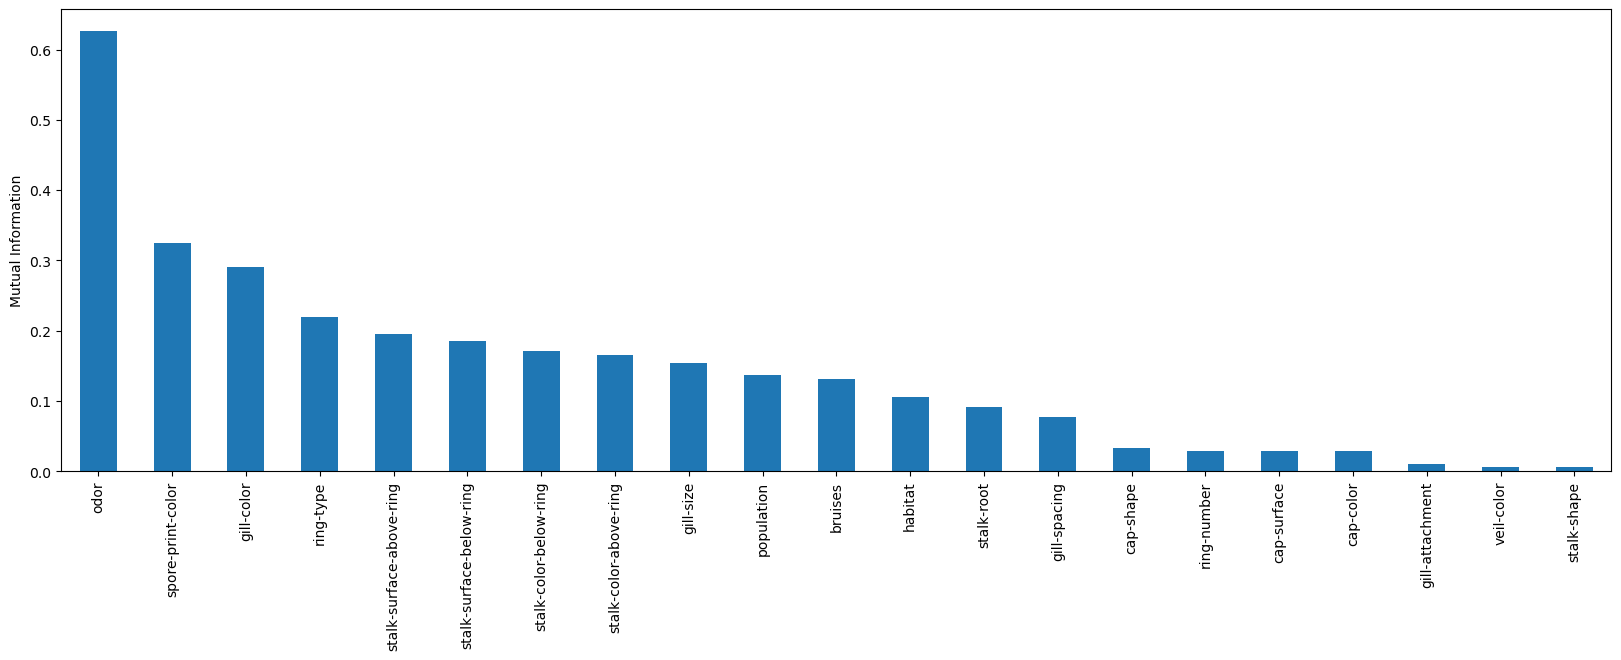

In [23]:
mi = pd.Series(mi)
mi.index = X_train_transform.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

Once we find the mutual information values, to select features we need to determine a threshold, or cut-off value, above which a feature will be selected.

There are a few ways in which this can be done:

- Select top k features, where k is an arbitrary number of features

- Select features in the top n percentile, where n is again an arbitrary number

- Select all features above a certain threshold of MI, arbitrarily decided.

Scikit-learn transformer **SelectKBest**, allows us to automatically select the top k features, based of any statistical value, including the MI.

Sklearn's **SelectPercentile** allows us to select the features in the top percentile of any statistical value, including the MI.

Alternatively, if we want to select features based on a MI threshold, we can do it manually.

### 4.2.1 SelectKBest example

In [30]:
# select features
sel_ = SelectKBest(mutual_info_classif, k=10).fit(X_train_transform, y_train)

# display features
X_train.columns[sel_.get_support()]

Index(['odor', 'gill-size', 'gill-color', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'ring-type', 'spore-print-color',
       'population'],
      dtype='object')

In [31]:
# to remove the rest of the features:
X_train_sel = sel_.transform(X_train)
X_test_sel = sel_.transform(X_test)
print(X_train_sel.shape, X_test_sel.shape)

(6499, 10) (1625, 10)


In [32]:
### Select top 10th percentile features

In [33]:
# Select the features in the top percentile
sel_ = SelectPercentile(mutual_info_classif, percentile=10).fit(X_train_transform, y_train)

# display the features
X_train_transform.columns[sel_.get_support()]

Index(['odor', 'spore-print-color'], dtype='object')

In [34]:
X_train_sel = sel_.transform(X_train)
X_test_sel = sel_.transform(X_test)
print(X_train_sel.shape, X_test_sel.shape)

(6499, 2) (1625, 2)
